In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pywt
import urllib.request
import zipfile
import os
import optuna
from optuna.samplers import TPESampler
from functools import partial
from scipy.io import arff

from aux_functions import timeseries_to_pandas
from aux_functions import pandas_to_numpy


# Configurações
plt.style.use('ggplot')
np.random.seed(42)

c:\Users\User\anaconda3\envs\PHD\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# pip install pywavelets

## Leitura dos dados

In [3]:
#Read data
data_train = {}
data_test = {}

for i in range(1,7):
    data_train[i] = arff.loadarff(os.path.join('SelfRegulationSCP1',
                                               f'SelfRegulationSCP1Dimension{i}_TRAIN.arff'))[0]
    data_test[i] = arff.loadarff(os.path.join('SelfRegulationSCP1',
                                               f'SelfRegulationSCP1Dimension{i}_TEST.arff'))[0]
    
#Convert to pandas dataframes
df_train = timeseries_to_pandas(data_train)
df_test = timeseries_to_pandas(data_test)

#Convert to numpy arrays
X_train, y_train = pandas_to_numpy(df_train)
X_test, y_test = pandas_to_numpy(df_test)



# Convertendo de bytes para string
y_train = np.array([y.decode('utf-8') if isinstance(y, bytes) else y for y in y_train])
y_test = np.array([y.decode('utf-8') if isinstance(y, bytes) else y for y in y_test])

label_map = {'negativity': 0, 'positivity': 1}

y_train = np.array([label_map[y] for y in y_train])
y_test = np.array([label_map[y] for y in y_test])


#Create folder structure and save the arrays
if not os.path.exists(os.path.join('Datasets_clean', 'SelfRegulationSCP1')):
    os.makedirs(os.path.join('Datasets_clean', 'SelfRegulationSCP1'))

np.save('Datasets_clean/SelfRegulationSCP1/X_train', X_train)
np.save('Datasets_clean/SelfRegulationSCP1/y_train', y_train)
np.save('Datasets_clean/SelfRegulationSCP1/X_test', X_test)
np.save('Datasets_clean/SelfRegulationSCP1/y_test', y_test)

### Dados processados

In [11]:
X_train = np.load('Datasets_clean/SelfRegulationSCP1/X_train.npy')
y_train = np.load('Datasets_clean/SelfRegulationSCP1/y_train.npy')  
X_test = np.load('Datasets_clean/SelfRegulationSCP1/X_test.npy')    
y_test = np.load('Datasets_clean/SelfRegulationSCP1/y_test.npy')

## Fast Wavelet Transform

In [ ]:
# --- Função para extrair features Wavelet 1D (coeficientes e estatísticas simples) ---
def extract_wavelet_features(X, wavelet='db4', level=3):
    """
    Extrai features baseadas na decomposição Wavelet dos sinais.

    Parâmetros:
    - X: array numpy de formato (n_amostras, n_canais, n_tempo)
    - wavelet: tipo de wavelet (ex.: 'db4')
    - level: nível de decomposição

    Retorna:
    - features: array (n_amostras, n_features)
    - feature_names: lista de nomes das features
    """
    dimension_names = ['Canal1_Fp1', 'Canal2_Fp2', 'Canal3_Cz', 
                        'Canal4_Pz', 'Canal5_O1', 'Canal6_O2']
    
    features = []
    feature_names = []

    for i in range(X.shape[0]):  # para cada amostra
        sample_features = []

        for dim in range(X.shape[1]):  # para cada dimensão (canal EEG)
            coeffs = pywt.wavedec(X[i, dim, :], wavelet, level=level)

            for j, coef in enumerate(coeffs):
                # estatísticas básicas dos coeficientes
                sample_features.append(np.mean(coef))
                sample_features.append(np.std(coef))
                sample_features.append(np.median(coef))
                sample_features.append(np.max(coef))
                sample_features.append(np.min(coef))

                # apenas uma vez, monta os nomes das features
                if i == 0:
                    base_name = f'{dimension_names[dim]}_coef{j}_'
                    feature_names += [
                        base_name + stat for stat in ['mean', 'std', 'median', 'max', 'min']
                    ]

        features.append(sample_features)

    return np.array(features), feature_names


In [ ]:
X_train_feat, feature_names = extract_wavelet_features(X_train)
X_test_feat, _ = extract_wavelet_features(X_test)

## Pipeline de modelos e otimização com Optuna

In [17]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, recall_score, precision_score
import pandas as pd

# Função de otimização
def objective(trial, model_name):
    if model_name == 'random_forest':
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 3, 20)
        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)

    elif model_name == 'lightgbm':
        num_leaves = trial.suggest_int('num_leaves', 15, 100)
        learning_rate = trial.suggest_float('learning_rate', 1e-3, 0.3, log=True)
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        clf = LGBMClassifier(num_leaves=num_leaves, learning_rate=learning_rate,
                             n_estimators=n_estimators, random_state=42)

    elif model_name == 'xgboost':
        max_depth = trial.suggest_int('max_depth', 3, 15)
        learning_rate = trial.suggest_float('learning_rate', 1e-3, 0.3, log=True)
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        clf = XGBClassifier(max_depth=max_depth, learning_rate=learning_rate,
                            n_estimators=n_estimators, use_label_encoder=False,
                            eval_metric='logloss', random_state=42)

    elif model_name == 'svm':
        C = trial.suggest_float('C', 1e-3, 100, log=True)
        gamma = trial.suggest_float('gamma', 1e-4, 1, log=True)
        clf = SVC(C=C, gamma=gamma, probability=True, random_state=42)

    else:
        raise ValueError('Unknown model')

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_train_feat, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores.mean()


## Otimização para todos os modelos

In [18]:
models = ['random_forest', 'lightgbm', 'xgboost', 'svm']
best_models = {}

for model in models:
    print(f'Optimizing {model}...')
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, model), n_trials=5)

    print(f'Best params for {model}: {study.best_params}')
    best_models[model] = study.best_params

[I 2025-05-31 20:08:13,259] A new study created in memory with name: no-name-a5e9c3a6-fac8-4626-ad55-7e0b75d0dcdc


Optimizing random_forest...


[I 2025-05-31 20:08:17,436] Trial 0 finished with value: 0.8054652006183277 and parameters: {'n_estimators': 64, 'max_depth': 19}. Best is trial 0 with value: 0.8054652006183277.
[I 2025-05-31 20:08:19,187] Trial 1 finished with value: 0.7925184625690611 and parameters: {'n_estimators': 280, 'max_depth': 3}. Best is trial 0 with value: 0.8054652006183277.
[I 2025-05-31 20:08:19,903] Trial 2 finished with value: 0.8278032275455638 and parameters: {'n_estimators': 95, 'max_depth': 19}. Best is trial 2 with value: 0.8278032275455638.
[I 2025-05-31 20:08:20,895] Trial 3 finished with value: 0.8128781225507469 and parameters: {'n_estimators': 143, 'max_depth': 17}. Best is trial 2 with value: 0.8278032275455638.
[I 2025-05-31 20:08:23,160] Trial 4 finished with value: 0.8054274739680227 and parameters: {'n_estimators': 254, 'max_depth': 19}. Best is trial 2 with value: 0.8278032275455638.
[I 2025-05-31 20:08:23,161] A new study created in memory with name: no-name-6e1e37d2-951e-42f2-8ff2-d8

Best params for random_forest: {'n_estimators': 95, 'max_depth': 19}
Optimizing lightgbm...


[I 2025-05-31 20:08:27,388] Trial 0 finished with value: 0.7932304246214906 and parameters: {'num_leaves': 19, 'learning_rate': 0.0013409349505055306, 'n_estimators': 180}. Best is trial 0 with value: 0.7932304246214906.
[I 2025-05-31 20:08:28,720] Trial 1 finished with value: 0.8205264280669387 and parameters: {'num_leaves': 95, 'learning_rate': 0.008702325532546733, 'n_estimators': 263}. Best is trial 1 with value: 0.8205264280669387.
[I 2025-05-31 20:08:29,202] Trial 2 finished with value: 0.8277789770964021 and parameters: {'num_leaves': 42, 'learning_rate': 0.054648094577652725, 'n_estimators': 84}. Best is trial 2 with value: 0.8277789770964021.
[I 2025-05-31 20:08:30,506] Trial 3 finished with value: 0.8126275028929901 and parameters: {'num_leaves': 27, 'learning_rate': 0.0025450098543035723, 'n_estimators': 280}. Best is trial 2 with value: 0.8277789770964021.
[I 2025-05-31 20:08:31,521] Trial 4 finished with value: 0.8203690285543782 and parameters: {'num_leaves': 88, 'learnin

Best params for lightgbm: {'num_leaves': 42, 'learning_rate': 0.054648094577652725, 'n_estimators': 84}
Optimizing xgboost...


[I 2025-05-31 20:08:37,575] Trial 0 finished with value: 0.8275989541095361 and parameters: {'max_depth': 4, 'learning_rate': 0.015405679375269248, 'n_estimators': 222}. Best is trial 0 with value: 0.8275989541095361.
[I 2025-05-31 20:08:47,169] Trial 1 finished with value: 0.8203453572365891 and parameters: {'max_depth': 10, 'learning_rate': 0.007715766018623112, 'n_estimators': 262}. Best is trial 0 with value: 0.8275989541095361.
[I 2025-05-31 20:08:47,759] Trial 2 finished with value: 0.8389486693366832 and parameters: {'max_depth': 3, 'learning_rate': 0.05523518656007499, 'n_estimators': 56}. Best is trial 2 with value: 0.8389486693366832.
[I 2025-05-31 20:08:51,478] Trial 3 finished with value: 0.8127441836353573 and parameters: {'max_depth': 15, 'learning_rate': 0.013425429207230291, 'n_estimators': 124}. Best is trial 2 with value: 0.8389486693366832.
[I 2025-05-31 20:08:55,901] Trial 4 finished with value: 0.7976468733529514 and parameters: {'max_depth': 10, 'learning_rate': 0

Best params for xgboost: {'max_depth': 3, 'learning_rate': 0.05523518656007499, 'n_estimators': 56}
Optimizing svm...


[I 2025-05-31 20:08:56,190] Trial 2 finished with value: 0.5477847423122254 and parameters: {'C': 2.598167647381175, 'gamma': 0.001631279930467207}. Best is trial 0 with value: 0.5477847423122254.
[I 2025-05-31 20:08:56,325] Trial 3 finished with value: 0.33499999999999996 and parameters: {'C': 49.75681787583558, 'gamma': 0.04939114445868273}. Best is trial 0 with value: 0.5477847423122254.
[I 2025-05-31 20:08:56,421] Trial 4 finished with value: 0.7154177761626528 and parameters: {'C': 0.6623169674802667, 'gamma': 0.0002608927866203661}. Best is trial 4 with value: 0.7154177761626528.


Best params for svm: {'C': 0.6623169674802667, 'gamma': 0.0002608927866203661}


## Avaliação Final

In [19]:
def train_best_model(model_name, params):
    if model_name == 'random_forest':
        model = RandomForestClassifier(**params, random_state=42)
    elif model_name == 'lightgbm':
        model = LGBMClassifier(**params, random_state=42)
    elif model_name == 'xgboost':
        model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss', random_state=42)
    elif model_name == 'svm':
        model = SVC(**params, probability=True, random_state=42)
    else:
        raise ValueError('Unknown model')
    return model

results = []

for model_name, params in best_models.items():
    model = train_best_model(model_name, params)
    model.fit(X_train_feat, y_train)
    y_pred = model.predict(X_test_feat)
    y_proba = model.predict_proba(X_test_feat)[:, 1] if hasattr(model, "predict_proba") else None

    metrics = {
        'Model': model_name,
        'F1_Score': f1_score(y_test, y_pred, average='macro'),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred, average='macro'),
        'Precision': precision_score(y_test, y_pred, average='macro'),
        'ROC_AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }
    results.append(metrics)

df_results = pd.DataFrame(results)
print(df_results)

[LightGBM] [Info] Number of positive: 133, number of negative: 135
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10808
[LightGBM] [Info] Number of data points in the train set: 268, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496269 -> initscore=-0.014926
[LightGBM] [Info] Start training from score -0.014926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [20]:
df_results

,Model,F1_Score,Accuracy,Recall,Precision,ROC_AUC
0,random_forest,0.748726,0.761092,0.761858,0.827277,0.890178
1,lightgbm,0.758789,0.767918,0.768591,0.817498,0.875035
2,xgboost,0.732823,0.744027,0.744735,0.795051,0.858960
3,svm,0.773793,0.774744,0.774974,0.779931,0.828418


## Explicabilidade 

In [21]:
for model_name, params in best_models.items():
    if model_name == 'random_forest':
        model = train_best_model(model_name, params)
        model.fit(X_train_feat, y_train)
        y_pred = model.predict(X_test_feat)
        y_proba = model.predict_proba(X_test_feat)[:, 1] if hasattr(model, "predict_proba") else None

In [22]:
model

RandomForestClassifier(max_depth=19, n_estimators=95, random_state=42)

In [23]:
import shap
# 6. Explicabilidade com SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_feat)


In [26]:
# Se shap_values for numpy array 3D (n_samples, n_features, 2)
if isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    shap_values_class1 = shap_values[:, :, 1]
else:
    # shap_values é lista [classe0, classe1]
    shap_values_class1 = shap_values[1]

print("Shape shap_values_class1:", shap_values_class1.shape)
print("Shape X_test_feat:", X_test_feat.shape)
print("Número de feature_names:", len(feature_names))

Shape shap_values_class1: (293, 120)
Shape X_test_feat: (293, 120)
Número de feature_names: 120


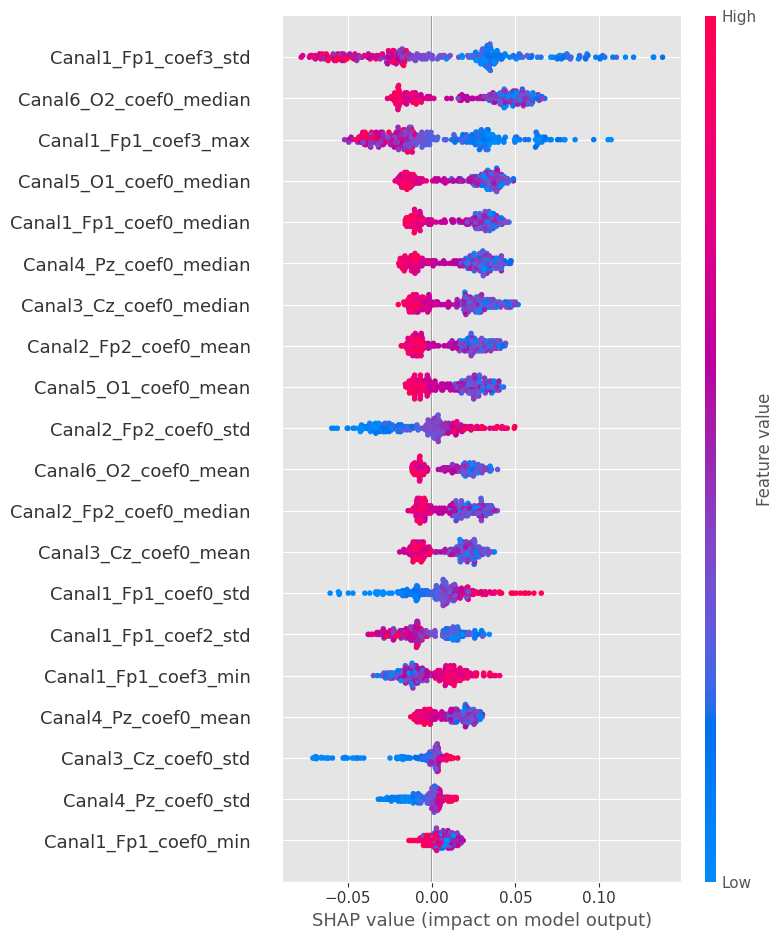

In [ ]:
shap.summary_plot(shap_values_class1, X_test_feat, feature_names=feature_names, max_display=20)

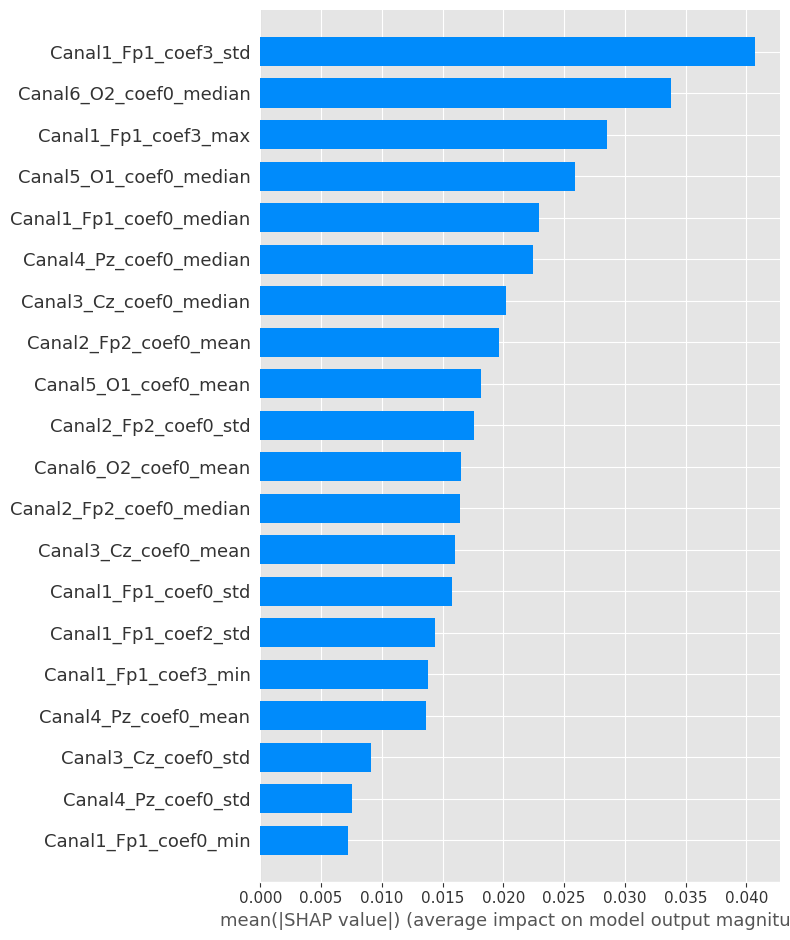

In [27]:
shap.summary_plot(shap_values_class1, X_test_feat, feature_names=feature_names, plot_type="bar", max_display=20)